### Repetition Cat Code
This notebook aims to replicates the numerical results for logical phase flip probabilities in the repetition cat code, as presented in [arxiv:2302.06639](https://arxiv.org/abs/2302.06639), Appendix E. 

The noise model follows Table I from the same paper, specifically focusing on distance \( d = 3 \) with noise in both state preparation and CX gates. The next steps will be to extend this approach to higher-distance repetition codes and apply model fitting as detailed in the original paper (Eq. E1).

In [1]:
from repetition_cat_code import *
import matplotlib.pyplot as plt

def run_cat_repetition_code(initial_state, kappa_ratio, alpha_squared, cycles=3, repetitions=1):
    """
    Simulates the logical phase flip correction of a three-qubit repetition cat code over a given number of cycles.
    
    Parameters:
        initial_state (np.array): Initial logical state to encode.
        kappa_ratio (float): k1/k2 (k1 is the single excitation loss rate, k2 is the engineered two-excitation dissipation rate).
        alpha_squared (float): Average cat qubit photon number.
        cycles (int): Number of error correction cycles. 
        repetitions (int): Number of simulation repetitions.
    
    Returns:
        float: The success rate of the logical error correction.
    """
    successes = 0
    # Define the ideal logical state for verification
    ideal_state = 1 / np.sqrt(2) * (tensor_product(Hadamard @ ket_0, Hadamard @ ket_0, Hadamard @ ket_0) +
                                     tensor_product(Hadamard @ ket_1, Hadamard @ ket_1, Hadamard @ ket_1))

    for _ in range(repetitions):
        encoded_state = encode_logical_state(initial_state, kappa_ratio, alpha_squared)
        current_state = encoded_state  # Start with the encoded state
        results = []
        
        # Loop over cycles
        for cycle in range(cycles):
            # Add ancilla qubits for error detection
            ancilla_added_state = add_ancilla_qubits(current_state, kappa_ratio, alpha_squared)
            
            # Measure the rightmost two qubits (ancilla qubits) to check for errors
            result = measure_rightmost_2_qubits(ancilla_added_state) #Need to add in noisy measurement
            results.append(result)  # Store the measurement result
            
            # Discard ancilla qubits to obtain the logical state
            current_state = discard_ancilla_from_statevector(ancilla_added_state)
            
        # Final measurement on the last cycle
        ancilla_added_state = add_ancilla_qubits(current_state, kappa_ratio, alpha_squared)
        final_result = measure_rightmost_2_qubits(ancilla_added_state) 
        results.append(final_result)

        final_state = discard_ancilla_from_statevector(ancilla_added_state)
        corrected_state = mwpm_correction(results, final_state)
        
        # Check if the corrected state matches the ideal logical state
        if np.allclose(corrected_state, ideal_state):
            successes += 1  # Count successful corrections
    
    # Calculate success rate
    success_rate = successes / repetitions
    return success_rate


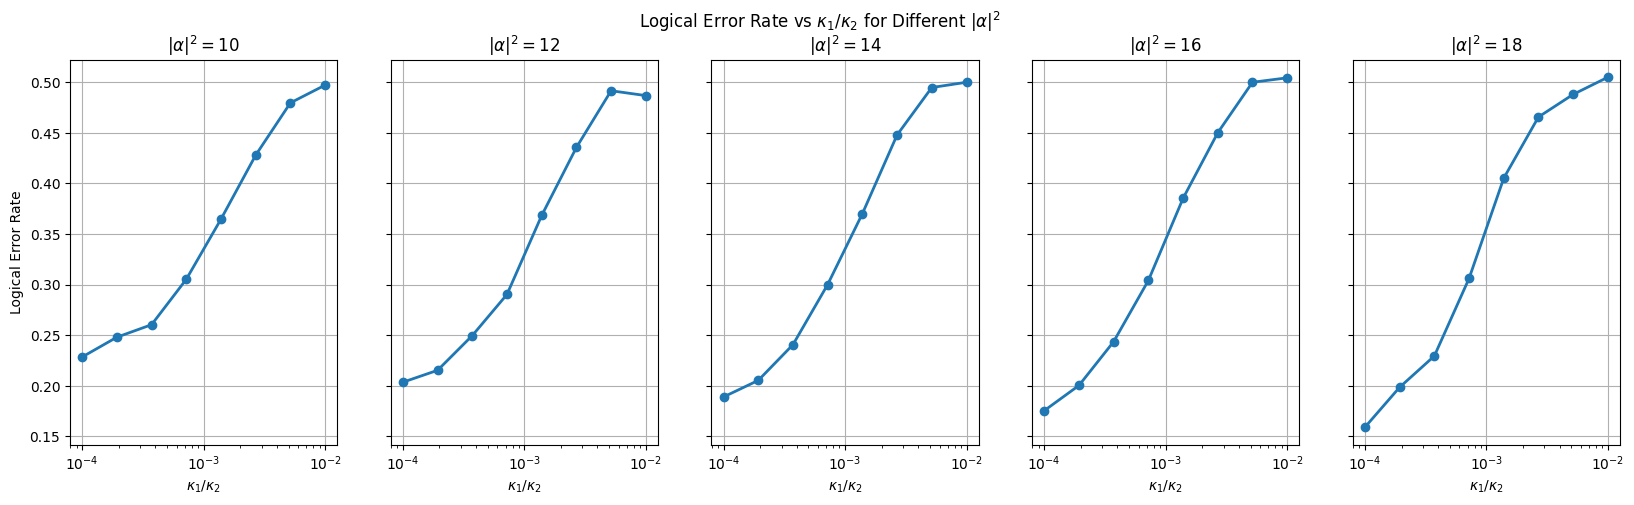

In [2]:
# Set parameters
cycles = 3
repetitions = 5012
kappa_ratios = np.logspace(-4, -2, num=8) # Define the range of kappa ratios
alpha_values = range(10, 19, 2)  # Values for alpha_squared
initial_state = np.dot(Hadamard, ket_0)
# Initialize plot
fig, axs = plt.subplots(1, len(alpha_values), figsize=(20, 5), sharey=True)
fig.suptitle('Logical Error Rate vs $ \\kappa_1 / \\kappa_2 $ for Different $ | \\alpha |^2 $')

# Run the simulation for each $ | \alpha |^2 $ value and plot
for i, alpha_squared in enumerate(alpha_values):
    logical_error_rates = []
    for kappa_ratio in kappa_ratios:
        success_rate = run_cat_repetition_code(initial_state, kappa_ratio, alpha_squared, cycles, repetitions)
        logical_error_rate = 1 - success_rate
        logical_error_rates.append(logical_error_rate)

    # Plot for the current $ | \alpha |^2 $ value
    axs[i].plot(kappa_ratios, logical_error_rates, marker='o', linestyle='-', linewidth=2)
    axs[i].set_xscale('log')
    axs[i].set_xlabel('$ \\kappa_1 / \\kappa_2 $')
    axs[i].set_title(f'$ | \\alpha |^2 = {alpha_squared} $')
    axs[i].grid(True)

# Set common y-label and show plot
axs[0].set_ylabel('Logical Error Rate')
plt.show()